# Clase 6: Feature Engineering
## DP-100 Azure Data Sienctist
## Dataset Utilizado: Hotel Booking
https://www.kaggle.com/datasets/mojtaba142/hotel-booking/data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher

sns.set_style("whitegrid")

# CREDENCIALES AZURE
ml_client = MLClient.from_config(credential=DefaultAzureCredential())
# METADATA ASSET
data_asset = ml_client.data.get("booking-dsrp", version="1")

Found the config file in: /config.json


In [6]:
reservas_hotel_raw = pd.read_csv(data_asset.path)
reservas_hotel_raw.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734


In [9]:
reservas_hotel_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [10]:
reservas_hotel_raw.hotel.value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

In [6]:
# ANALISIS DE LOS CLIENTES NUEVOS EN SU ADR
# ADR: https://www.investopedia.com/terms/a/average-daily-rate.asp#:~:text=The%20average%20daily%20rate%20(ADR)%20is%20a%20metric%20widely%20used,(KPI)%20of%20the%20industry.
reservas_hotel_raw[reservas_hotel_raw["is_repeated_guest"]==0].groupby("is_canceled").agg({"adr": [np.mean, np.min, np.max]})

adr             
                   mean  min     max
is_canceled                         
0            101.670375  0.0   510.0
1            105.357324  0.0  5400.0

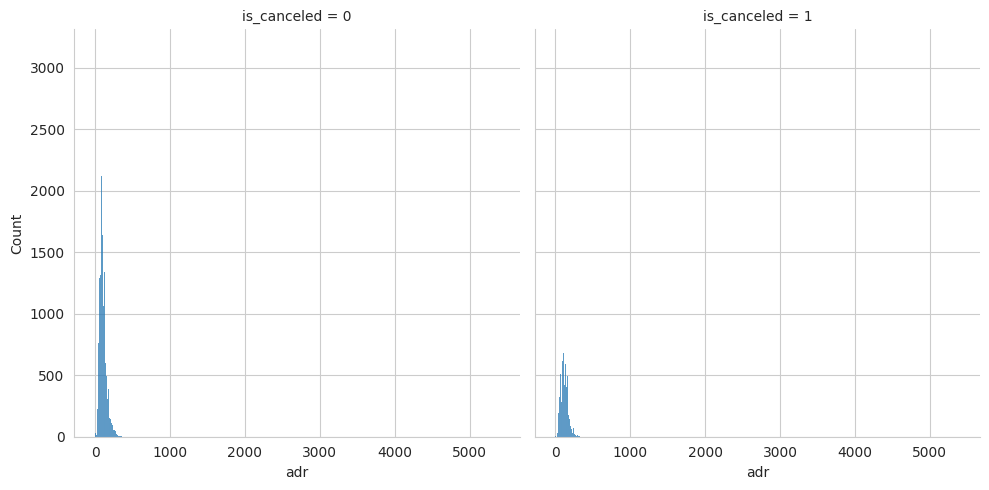

In [8]:
sns.displot(data=reservas_hotel_raw, x="adr", col="is_canceled")

## Pipeline de procesamiento

In [10]:
encoder = OneHotEncoder()
year_encoder = encoder.fit(reservas_hotel_raw[['arrival_date_year']])
_encoded_years = year_encoder.transform(reservas_hotel_raw[['arrival_date_year']]).toarray()

pd.DataFrame(_encoded_years, columns = year_encoder.get_feature_names_out())

,arrival_date_year_2015,arrival_date_year_2016,arrival_date_year_2017
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
119385,0.0,0.0,1.0
119386,0.0,0.0,1.0
119387,0.0,0.0,1.0
119388,0.0,0.0,1.0


In [20]:
class DataProcessor:
    '''
    Preprocesamiento de datos de hotel
    '''

    def __init__(self, data: pd.DataFrame):
        self.data = data

    def __encode_with_ohe(self, col_name:str):
        '''
        One hot encoding de cualquier columna
        '''
        encoder = OneHotEncoder()
        fitted_encoder = encoder.fit(self.data[[col_name]])
        encoded_array = fitted_encoder.transform(self.data[[col_name]]).toarray()

        encoded_df = pd.DataFrame(encoded_array, columns = fitted_encoder.get_feature_names_out())
        return encoded_df


    def process(self):

        # el hotel esta en la ciudad
        self.data['is_city_hotel'] = np.where(self.data['hotel']=='City Hotel',1,0)
        self.data = self.data.drop('hotel', axis=1)

        # OHE years
        years_encoded_df = self.__encode_with_ohe(col_name='arrival_date_year')
        self.data = pd.concat([self.data, years_encoded_df], axis=1)
        self.data = self.data.drop('arrival_date_year', axis=1)

        # OHE months
        years_encoded_df = self.__encode_with_ohe(col_name='arrival_date_month')
        self.data = pd.concat([self.data, years_encoded_df], axis=1)
        self.data = self.data.drop('arrival_date_month', axis=1)

In [21]:
processor = DataProcessor(data=reservas_hotel_raw)
processor.process()

In [22]:
processor.data.tail()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September
119385,0,23,35,30,2,5,2,0.0,0,BB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119386,0,102,35,31,2,5,3,0.0,0,BB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119387,0,34,35,31,2,5,2,0.0,0,BB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119388,0,109,35,31,2,5,2,0.0,0,BB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119389,0,205,35,29,2,7,2,0.0,0,HB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
